# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()
data.describe()
data.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

* Il n'y a pas de valeurs manquantes : pas besoin d'imputation
* Pas besoin de label encoder
* new_user, country, source est catégorielle : mais pas besoin d'encoder
* age et pages visitées sont quantitatives : on doit les normaliser
* ATTENTION : outliers dans Age : 123 ans ! 

In [4]:
#filtrer que les ages < 90
data = data[data['age'] < 90]

# Explore dataset

In [5]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [6]:
# Visualize pairwise dependencies before taking out outliers
fig = px.scatter_matrix(data_sample)
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 800)
fig.show()

In [7]:
# pip install kaleido

# Preprocessing 
classification model as Y (target = conversion) is categorical ! 

In [8]:
# définition features :

features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target_variable = 'converted'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [9]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [10]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

num_featureencoder = StandardScaler()
num_features = ['age', 'total_pages_visited']

cat_featureencoder = OneHotEncoder(drop='first')
cat_features = ['country', 'new_user', 'source']

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_featureencoder, num_features),
        ('cat', cat_featureencoder, cat_features)
    ])

print("Preprocessing done")

Encoding categorical features and standardizing numerical features...
Preprocessing done


In [11]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Performing preprocessings on train set...
...Done.
[[-1.51987065 -0.26099836  0.          0.          1.          0.
   0.          1.        ]
 [ 2.2307148   0.03829244  0.          0.          0.          0.
   0.          1.        ]
 [ 1.86775492 -0.56028917  0.          0.          0.          1.
   0.          1.        ]
 [-1.51987065 -1.15887077  0.          0.          1.          0.
   0.          0.        ]
 [-1.03592414  0.33758325  0.          0.          1.          1.
   0.          0.        ]]

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set...
...Done
[[-0.79395089  2.73190968  0.          0.          0.          1.
   0.          0.        ]
 [ 0.53690202  0.03829244  0.          0.          1.          0.
   1.          0.        ]
 [-0.18901775 -0.26099836  0.          0.          1.          0.
   1.          0.        ]
 [ 0.0529555   0.93616485  0.          0.          0.          1.
   0.          1. 

# Model Training

In [12]:
# Train model
print("Train model...")
classifier = SVC(kernel = 'linear', probability = True) 
classifier.fit(X_train, Y_train)


print("...Done.")


Train model...
...Done.


In [13]:
# Cross validation pour avoir une incertitude
scores = cross_val_score(classifier, X_train, Y_train, scoring = "f1", cv=5)
print('The cross-validated is : ', scores.mean())
print('The standard deviation is : ', scores.std())

The cross-validated is :  0.7576586833750272
The standard deviation is :  0.010063826790941892


# Perform grid search for non linear svc
print("Grid search...")
classifier = SVC(kernel = 'rbf', probability = True)

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0, 100],
    'gamma': [0.001, 0.01, 0.1, 1.0, 10.0]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

classifier = gridsearch.best_estimator_


### Grid search of values for logistic regression
print("Grid search...")
parameters = [{'penalty':['l1','l2']}, 
              {'C':[1, 10, 100, 1000]}]

grid_search = GridSearchCV(estimator = classifier,  
                           param_grid = parameters,
                           scoring = 'f1',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train, Y_train)  
print("...Done.")
print("Best hyperparameters : ", grid_search.best_params_)
print("Best validation accuracy : ", grid_search.best_score_) 

classifier = grid_search.best_estimator_

### Grid of values for decision tree to be tested
params = {
    'max_depth': [11, 15, 20],
    'min_samples_leaf': [6, 10, 20],
    'min_samples_split': [1, 2, 3]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 10) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy gini: ", gridsearch.best_score_)
print("...Done.")

# Predictions et résultats

In [14]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# Concatenate our train and test set to train your best classifier on all data with labels
X_total = np.append(X_train,X_test,axis=0)
Y_total = np.append(Y_train,Y_test)

classifier.fit(X_total,Y_total)
print("Predictions on test set...")
Y_total_pred = classifier.predict(X_total)
print("...Done.")

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Predictions on test set...
...Done.


## Performance assessment

In [15]:
print('The cross-validated is : ', scores.mean())
print('The standard deviation is : ', scores.std())
print('Value should be between :', round(scores.mean()-scores.std(), 3), "and", round(scores.mean()+scores.std(), 3))
print('')
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print("f1-score on entire set : ", f1_score(Y_total, Y_total_pred))

The cross-validated is :  0.7576586833750272
The standard deviation is :  0.010063826790941892
Value should be between : 0.748 and 0.768

f1-score on train set :  0.7582648835788475
f1-score on test set :  0.7617306520414381
f1-score on entire set :  0.7583256950809655


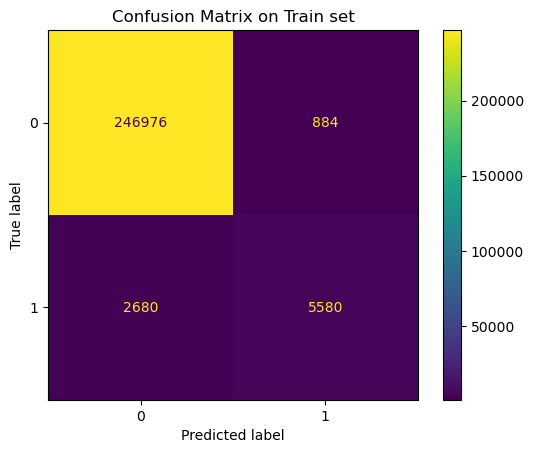

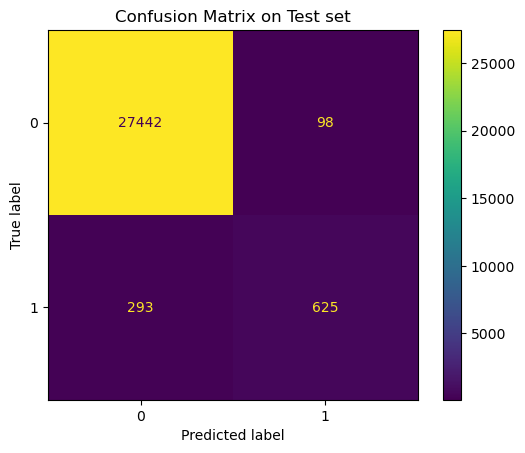

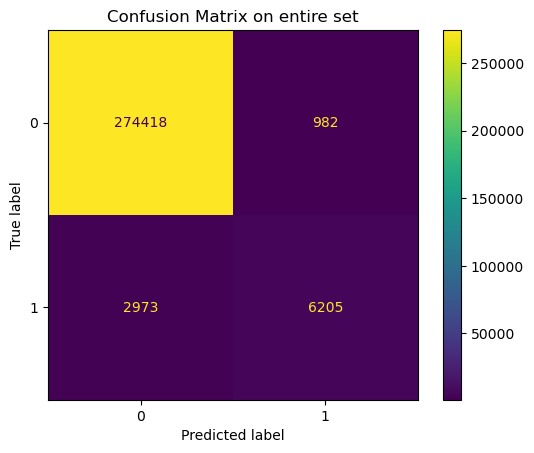

In [16]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on entire set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_total, Y_total, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()


In [17]:
%time
print("Report on Train set : \n" + classification_report(Y_train, Y_train_pred))
print("Report on Train set : \n" + classification_report(Y_test, Y_test_pred))
print("Report on Train set : \n" + classification_report(Y_total, Y_total_pred))

Wall time: 0 ns
Report on Train set : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    247860
           1       0.86      0.68      0.76      8260

    accuracy                           0.99    256120
   macro avg       0.93      0.84      0.88    256120
weighted avg       0.99      0.99      0.99    256120

Report on Train set : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27540
           1       0.86      0.68      0.76       918

    accuracy                           0.99     28458
   macro avg       0.93      0.84      0.88     28458
weighted avg       0.99      0.99      0.99     28458

Report on Train set : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    275400
           1       0.86      0.68      0.76      9178

    accuracy                           0.99    284578
   macro avg       0.93      0.84      0.88

### Prédictions sur TEST set + écriture

In [18]:
%time
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
#print("Convert pandas DataFrames to numpy arrays...")
#X_without_labels = X_without_labels.values
#print("...Done")

# print(X_without_labels[0:5,:])

Wall time: 0 ns
Prediction set (without labels) : (31620, 5)


In [19]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31000438  3.33049128  0.          1.          0.          0.
   0.          1.        ]
 [-1.03592414  0.03829244  0.          1.          0.          1.
   1.          0.        ]
 [ 0.17394213 -1.15887077  0.          0.          0.          1.
   0.          1.        ]
 [ 0.17394213  0.33758325  0.          0.          1.          1.
   0.          0.        ]
 [-0.67296426 -0.56028917  0.          0.          0.          0.
   0.          1.        ]]


In [20]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data_end = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data_end)
Y_predictions.to_csv('conversion_data_test_predictions_CTang-model8.csv', index=False)
